In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree

Matplotlib created a temporary config/cache directory at /var/folders/_n/4rn71s9d0kbcfsx7vgnkblrc0000gn/T/matplotlib-876ymyty because the default path (/Users/zhenhan/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
train = pd.read_csv("/Users/zhenhan/Desktop/深度学习/data/房屋数据（2011.8-2015.6）.csv")
train_isna = []
for col in train.columns:
    if train[col].isna().sum() / train.shape[0] > 0.4:
        train_isna.append(col)
df = train.drop(train_isna, axis=1)
df_num = df.select_dtypes(include=['int64', 'float64'])
df_obj = df.select_dtypes(include=['object'])
df_num_means = df_num.median()
df_num = df_num.fillna(df_num_means)
df_num.isna().sum().value_counts()
df_num = df_num.iloc[:,1:]
df_obj = df_obj.iloc[:,1:]
df_obj_map = {"poor":0, "no data":2, "satisfactory":2, "good":3, "excellent":4}
df_obj["ecology"] = df_obj["ecology"].map(df_obj_map)
label_encoder = LabelEncoder()
df_obj['sub_area'] = label_encoder.fit_transform(df_obj['sub_area'])
df_obj = pd.get_dummies(df_obj, columns=df_obj.columns[2:14], prefix=df_obj.columns[2:14])
df_obj = pd.get_dummies(df_obj, columns=['product_type'], prefix=['product_type'])
target_column = df_num.columns[-1]
# for col in df_num.columns:
#     correlation = df[col].corr(df[target_column])
#     if abs(correlation) <= 0.05:
#         df_num = df_num.drop(col, axis=1)
data = pd.concat([df_num, df_obj], axis=1)
X = data.drop('price_doc', axis=1)
y = data['price_doc']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.66, random_state=42)
initx_val = X_val
inity_val = y_val

[0]	train-rmse:8330905.61310	val-rmse:8089590.38563
[20]	train-rmse:4308870.99569	val-rmse:4367272.25586
[40]	train-rmse:2693045.05003	val-rmse:3062657.93244
[60]	train-rmse:2082653.42543	val-rmse:2685648.27194
[80]	train-rmse:1828686.24368	val-rmse:2589773.71252
[100]	train-rmse:1710400.67824	val-rmse:2560628.80384
[120]	train-rmse:1627907.13226	val-rmse:2552923.19456
[140]	train-rmse:1565465.30925	val-rmse:2548388.48321
[160]	train-rmse:1516010.11568	val-rmse:2546433.18362
[180]	train-rmse:1465862.47792	val-rmse:2550065.73974
[200]	train-rmse:1419779.39636	val-rmse:2551334.41277
[220]	train-rmse:1378438.26995	val-rmse:2553547.53352
[235]	train-rmse:1350767.84262	val-rmse:2553137.13336
Root Mean Squared Error: 2619353.0424911347
R2: 0.6880809631853239


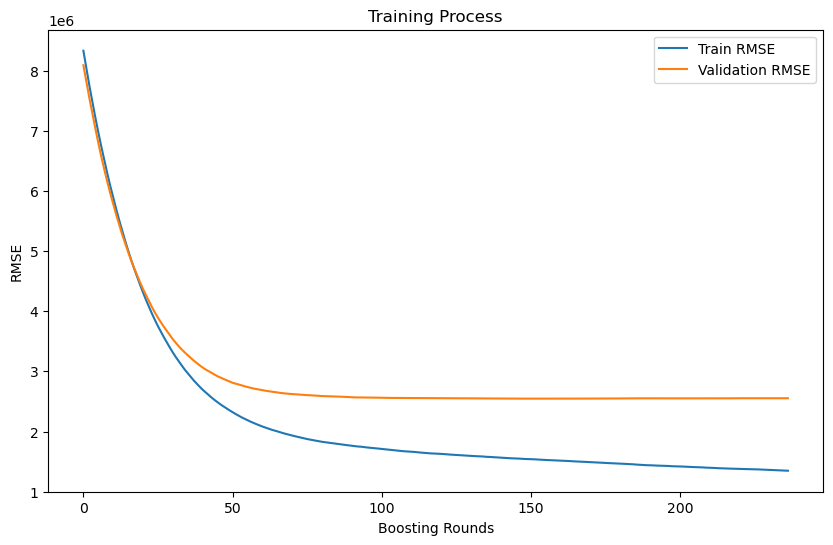

In [9]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test)

params = {
    'max_depth': 8,
    'learning_rate': 0.04,
    'booster': 'gbtree', # [gbtree, dart, gblinear]
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'random_state': 42
}

num_round = 400

history = {}

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=80,
    verbose_eval=20,
    evals_result=history
)

train_rmse = history['train']['rmse']
val_rmse = history['val']['rmse']

predictions = xgb_model.predict(dtest)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training Process')
plt.legend()
plt.show()

[LightGBM] [Info] Total Bins 39924
[LightGBM] [Info] Number of data points in the train set: 21329, number of used features: 296
[LightGBM] [Info] Start training from score 7144163.281823
Training until validation scores don't improve for 80 rounds
[20]	training's rmse: 2.70646e+06	valid_1's rmse: 2.74334e+06
[40]	training's rmse: 2.4026e+06	valid_1's rmse: 2.60988e+06
[60]	training's rmse: 2.27819e+06	valid_1's rmse: 2.57931e+06
[80]	training's rmse: 2.19329e+06	valid_1's rmse: 2.5877e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 2.12734e+06	valid_1's rmse: 2.59412e+06
[120]	training's rmse: 2.07327e+06	valid_1's rmse: 2.59125e+06
[140]	training's rmse: 2.02009e+06	valid_1's rmse: 2.59596e+06
Early stopping, best iteration is:
[68]	training's rmse: 2.24076e+06	valid_1's rmse: 2.5763e+06
Root Mean Squared Error: 2607534.0800183318
R2: 0.6908894751669389


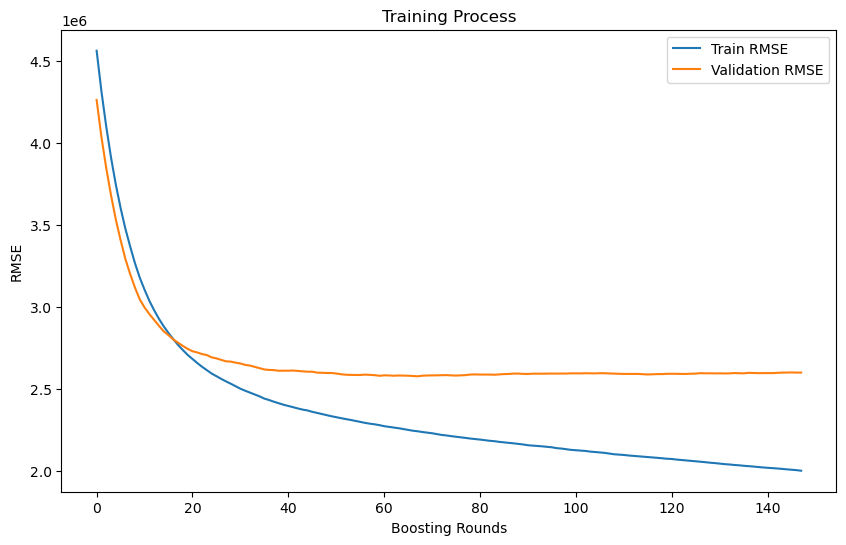

In [10]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def record_evaluation(results):
    # This callback function will be used to record evaluation results during training
    history['training']['rmse'].append(results['training']['rmse'])
    history['valid_1']['rmse'].append(results['valid_1']['rmse'])

dtrain = lgb.Dataset(data=X_train, label=y_train)
dval = lgb.Dataset(data=X_val, label=y_val, reference=dtrain)  # Set reference to dtrain for consistent validation
dtest = lgb.Dataset(data=X_test, label=y_test)

params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',  # ['gbdt', 'dart', 'goss', 'rf']
    'objective': 'regression',
    'metric': 'rmse',
    'colsample_bytree': 1.0,
    'subsample': 0.7,
    'reg_alpha': [0.01],
    'reg_lambda': [0.001],
    'min_child_samples':[20],
    'min_child_weight':[0.001],
    'num_leaves': 20,  # Set an appropriate value based on your dataset
    'random_state': 42,
    'force_col_wise': True  # Use column-wise multi-threading
}

num_round = 400

history = {'training': {'rmse': []}, 'valid_1': {'rmse': []}}

callbacks = [lgb.record_evaluation(history), lgb.log_evaluation(period=20,show_stdv=True), lgb.early_stopping(stopping_rounds=80,verbose=True)]

lgb_model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=num_round,
    valid_sets=[dtrain, dval],
    callbacks=callbacks
)

predictions = lgb_model.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.figure(figsize=(10, 6))
plt.plot(history['training']['rmse'], label='Train RMSE')
plt.plot(history['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training Process')
plt.legend()
plt.show()

0:	learn: 4767743.8608145	test: 4456049.9984676	best: 4456049.9984676 (0)	total: 78.6ms	remaining: 1m 18s
200:	learn: 2285951.3033623	test: 2564103.4386689	best: 2564103.4386689 (200)	total: 5.9s	remaining: 23.4s
400:	learn: 2084780.4791657	test: 2530720.9756530	best: 2530623.6041078 (399)	total: 11.4s	remaining: 17.1s
600:	learn: 1928272.8535660	test: 2520171.1512417	best: 2519930.6376197 (559)	total: 17.1s	remaining: 11.4s
800:	learn: 1810179.4802441	test: 2513169.8725058	best: 2512280.6959664 (780)	total: 22.7s	remaining: 5.65s
999:	learn: 1708355.9362433	test: 2511082.7028021	best: 2509733.4792317 (946)	total: 28.1s	remaining: 0us

bestTest = 2509733.479
bestIteration = 946

Shrink model to first 947 iterations.
Root Mean Squared Error: 2603991.126877925
R2: 0.691728904337249


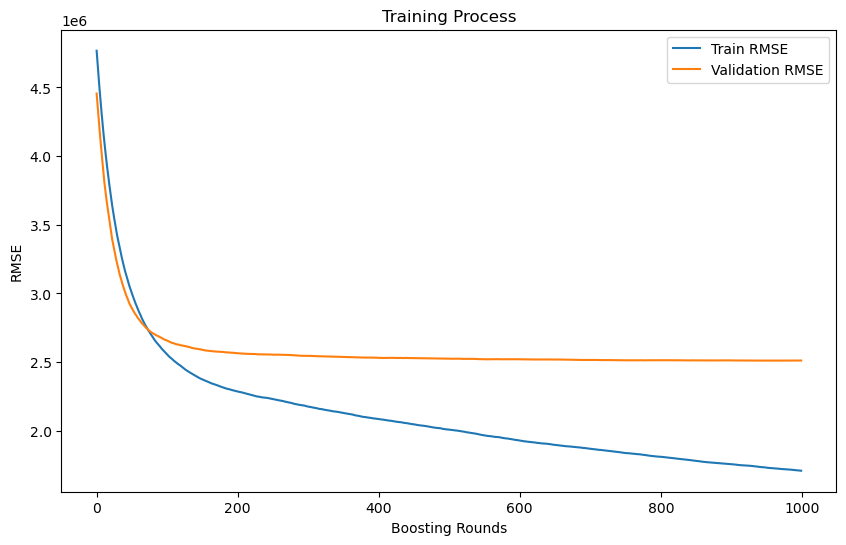

In [11]:
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

params = {
    'depth': 9,  
    'learning_rate': 0.03,
    'feature_border_type': 'GreedyLogSum',
    'boosting_type': 'Plain',
    'bagging_temperature': 0.5

}

num_round = 1000

history = {'training': {'rmse': []}, 'valid_1': {'rmse': []}}

catboost_model = CatBoostRegressor(
    iterations=num_round,
    eval_metric='RMSE',
    train_dir='catboost_info',
    loss_function='RMSE',
    random_state=42,
    **params
)

catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    verbose=200,
    early_stopping_rounds=100
)

history['training']['rmse'] = catboost_model.evals_result_['learn']['RMSE']
history['valid_1']['rmse'] = catboost_model.evals_result_['validation']['RMSE']

predictions = catboost_model.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

plt.figure(figsize=(10, 6))
plt.plot(history['training']['rmse'], label='Train RMSE')
plt.plot(history['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training Process')
plt.legend()
plt.show()

In [12]:
"""
第一层 train model 3 input feature
第二层 linear input model3 pre(val) y y_val
"""

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

dval = xgb.DMatrix(data=initx_val)
xgb_preds = xgb_model.predict(dval)
lgb_preds = lgb_model.predict(initx_val)
catboost_preds = catboost_model.predict(initx_val)

meta_features = np.column_stack((xgb_preds, lgb_preds, catboost_preds))

meta_model = LinearRegression()
# meta_model = LogisticRegression()

meta_model.fit(meta_features, inity_val)

meta_test_features = np.column_stack((
    xgb_model.predict(xgb.DMatrix(data=X_test)),
    lgb_model.predict(X_test),
    catboost_model.predict(X_test)
))

meta_preds = meta_model.predict(meta_test_features)

rmse = mean_squared_error(y_test, meta_preds, squared=False)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(y_test, meta_preds)
print("R2:", r2)

print(meta_model.coef_)


Root Mean Squared Error: 2586471.272762539
R2: 0.6958630934675876
[0.17895141 0.06891435 0.79386508]


In [22]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

class MyStacking:

    def __init__(self, estimators, final_estimator, cv=5, method='predict'):
        self.cv = cv
        self.method = method
        self.estimators = estimators
        self.final_estimator = final_estimator

    def fit(self, X, y):
        dataset_train = self.stacking(X, y)

        self.final_estimator.fit(dataset_train, y)

    def stacking(self, X_train, y_train):
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        dataset_train = np.zeros((X_train.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            for (train_idx, val_idx) in kf.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                y_val_pred = model.fit(X_train_fold, y_train_fold, 
                                       eval_set=[(X_val_fold, y_val_fold)], 
                                       verbose=100).predict(X_val_fold)
                
                dataset_train[val_idx, i] = y_val_pred
            self.estimators[i] = model
        return dataset_train

    def predict(self, X):
        datasets_test = np.zeros((X.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            datasets_test[:, i] = model.predict(X)

        return self.final_estimator.predict(datasets_test)

xgb_params = {
    'max_depth': 8,
    'learning_rate': 0.04,
    'booster': 'gbtree',
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'random_state': 42,
    'early_stopping_rounds': 100
}

lgb_params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',  # ['gbdt', 'dart', 'goss', 'rf']
    'objective': 'regression',
    'metric': 'rmse',
    'colsample_bytree': 1.0,
    'subsample': 0.7,
    'reg_alpha': [0.01],
    'reg_lambda': [0.001],
    'min_child_samples':[20],
    'min_child_weight':[0.001],
    'num_leaves': 20,  # Set an appropriate value based on your dataset
    'random_state': 42,
    'force_col_wise': True  # Use column-wise multi-threading
}

catboost_params = {
    'depth': 9,  
    'learning_rate': 0.03,
    'feature_border_type': 'GreedyLogSum',
    'boosting_type': 'Plain',
    'bagging_temperature': 0.5,
    'eval_metric':'RMSE',
    'train_dir': 'catboost_info',
    'loss_function': 'RMSE',
    'random_state':42
}

estimators = [
       XGBRegressor(
            n_estimators=100,
            **xgb_params),
            
        CatBoostRegressor(
            iterations=100,
            **catboost_params),
        
        LGBMRegressor(
            n_estimators=100,
            **lgb_params
        )
]

clf = MyStacking(estimators=estimators, final_estimator=LinearRegression())

clf.fit(X_train, y_train)


[0]	validation_0-rmse:8048730.06784
[99]	validation_0-rmse:2555606.97861
[0]	validation_0-rmse:8353573.00020
[99]	validation_0-rmse:2743560.27770
[0]	validation_0-rmse:7996656.09035
[99]	validation_0-rmse:2598127.17046
[0]	validation_0-rmse:8738276.87504
[99]	validation_0-rmse:3366155.53916
[0]	validation_0-rmse:8559967.97854
[99]	validation_0-rmse:2868363.36481
0:	learn: 4854177.0051694	test: 4387819.6010998	best: 4387819.6010998 (0)	total: 134ms	remaining: 13.2s
99:	learn: 2602244.2940152	test: 2645725.7799624	best: 2645725.7799624 (99)	total: 3.54s	remaining: 0us

bestTest = 2645725.78
bestIteration = 99

0:	learn: 4767479.7718379	test: 4751415.3352632	best: 4751415.3352632 (0)	total: 64.5ms	remaining: 6.38s
99:	learn: 2546217.2815837	test: 2938449.0102853	best: 2938449.0102853 (99)	total: 3.49s	remaining: 0us

bestTest = 2938449.01
bestIteration = 99

0:	learn: 4876707.8357059	test: 4297393.4829981	best: 4297393.4829981 (0)	total: 62ms	remaining: 6.14s
99:	learn: 2584535.5360030	te

/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 2.51198e+06


/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 2.78134e+06


/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 2.65813e+06


/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 3.22435e+06


/Users/zhenhan/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's rmse: 2.84994e+06


In [23]:
print(mean_squared_error(y_test, clf.predict(X_test), squared=False))
print(r2_score(y_test, clf.predict(X_test)))

2608534.9857582604
0.6906521245750943


In [ ]:
# from sklearn.linear_model import LinearRegression

# xgb_preds_train = xgb_model.predict(xgb.DMatrix(data=X_train))
# lgb_preds_train = lgb_model.predict(X_train)
# catboost_preds_train = catboost_model.predict(X_train)

# xgb_preds_test = xgb_model.predict(xgb.DMatrix(data=X_test))
# lgb_preds_test = lgb_model.predict(X_test)
# catboost_preds_test = catboost_model.predict(X_test)

# X_train_second = np.column_stack((xgb_preds_train, lgb_preds_train, catboost_preds_train))
# X_test_second = np.column_stack((xgb_preds_test, lgb_preds_test, catboost_preds_test))

# meta_model = LinearRegression()
# meta_model.fit(X_train_second, y_train)

# meta_preds = meta_model.predict(X_test_second)

# rmse = mean_squared_error(y_test, meta_preds, squared=False)
# print("Root Mean Squared Error:", rmse)

# r2 = r2_score(y_test, meta_preds)
# print("R2:", r2)

# print(meta_model.coef_)


In [11]:
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X = data['data']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

k = 5
kf = KFold(n_splits=k, random_state=42, shuffle=True)

In [14]:
for train_idx, val_index in kf.split(X_train):
    # print(train_idx)
    print(val_index)
    data = X_train[val_index]
    break

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
